# Bayesian Dynamic Linear Model for Election Forecasting

## Adam Gayoso and Srikar Varadaraj

## Introduction

The electoral victory of Donald Trump in November 2016 was widely viewed as an upset victory over Hillary Clinton. Various academic and journalistic sources ran forecasting models for the election, with many giving Clinton over a 90% chance of victory. Here we revisit the election and use a Bayesian dynamic linear model adapated from Linzer and Kremp to develop our own forecast of the election. By incorporating the uncertainty of undecided voters in the polls, we believe that Hillary Clinton had approximately a 70% chance of victory on election night. We will intersperse our model with its corresponding code. 

In [33]:
import pandas as pd
import numpy as np
import edward as ed
import tensorflow as tf
from edward.models import Normal, Binomial, MultivariateNormalFullCovariance, Empirical
from scipy.special import logit
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import collections

import sys
sys.path.insert(0, '../src')
from helper import *
from plots import *

ELECTION_DATE = dt.date(2016, 11, 8)
BURN_IN = 7000
pd.options.mode.chained_assignment = None

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2016 Results

In 2016, we witnessed the second time since 2000 that the winning candidate lost the popular vote. The polling data from May 1, 2016 to election day on November 8, 2016 suggested that Hillary Clinton had an electoral college "firewall". In essence, this means that basic polling averages and advanced forecasting models showed that Clinton had an advantage in more than enough states to secure the 270 electoral votes necessary to win the election.

<img src="images/firewall.png" alt="Drawing" style="width: 800px;"/>

[image source](https://projects.fivethirtyeight.com/2016-election-forecast/#stateorder)

<img src="images/undecided4.png" alt="Drawing" style="width: 800px;"/>

[image source](https://www.nytimes.com/interactive/2016/11/13/upshot/putting-the-polling-miss-of-2016-in-perspective.html?_r=0)

Below we see the actual results from the election. Clinton's firewall eroded with Trump securing Pennsylvania, Wisconsin, and Michgican, all states that Clinton was projected to win with high probability. 

<img src="images/2016_results.png" alt="Drawing" style="width: 800px;"/>

[image source](http://www.cnn.com/election/results)

## Criticism of 2016 Models

Below we see the final forecasted probability ([source](https://www.buzzfeed.com/jsvine/2016-election-forecast-grades?utm_term=.dsWz0w4MY#.rf1MnvgVW)) that Trump wins the electoral college from many of the most popular forecasters.

|            Organization           	| Pr(Trump wins) 	|
|:---------------------------------:	|---------------:	|
|          FiveThirtyEight          	|           0.29 	|
|             PollSavvy             	|           0.18 	|
|    The New York Times / Upshot    	|           0.15 	|
|           Kremp / Slate           	|           0.10 	|
|         Linzer / Daily Kos        	|           0.08 	|
|        The Huffington Post        	|           0.02 	|
| The Princeton Election Consortium 	|           0.01 	|

### Why were the probabilities so low?

As stated earlier, the polls showed a Clinton advantage, but the results of the election showed a small national polling error coupled with a larger polling error in some states. The state polling errors were largely caused by the high number of undecided voters.

<img src="images/undecided.png" alt="Drawing" style="width: 600px;"/>

[image source](http://fivethirtyeight.com/features/the-invisible-undecided-voter/)

So not only were there a high number of undecided voters, many of the voters who decided in the last week went for Trump, which indicates a systemic correlated polling error.

<img src="images/undecided2.png" alt="Drawing" style="width: 600px;"/>

[image source](http://fivethirtyeight.com/features/why-fivethirtyeight-gave-trump-a-better-chance-than-almost-anyone-else/)

From the list above, only FiveThirtyEight placed an emphasis on accounting for undecided voters.

## Bayesian Dynamic Linear Model for Two-Party Voter Share

## Data

The data consists of polls from May 1, 2016 to November 6, 2016. The polls come from the Huffington Post's Pollster database and consist of national polls and state polls. A pollster is a firm that gives a poll. We remove any polls that have overlapping dates and are from the same pollster in the same state. Since polls are taken over several days, we calculate the poll date as the midpoint date in the poll's date range. While more than two candidates run for president, we only consider Hillary Clinton and Donald Trump, as well as undecided voters in each poll.

In [2]:
polls = pd.read_csv('../data/all_polls_2016.csv', parse_dates=['begin', 'end', 'poll_date'])
up_to_t = dt.date(2016, 11, 8)
state_polls, national_polls = prepare_polls(polls, up_to_t)

# Get prior information from 2012 election
prior_diff_score, state_weights, ev_states = process_2012_polls()
states = state_polls.state.unique()
prior_diff_score = prior_diff_score[states]
state_weights = state_weights[states].as_matrix()
state_weights_np = state_weights
state_weights = tf.convert_to_tensor(state_weights, dtype=tf.float32)
ev_states = ev_states[states].as_matrix()

n_states = len(states)
n_pollsters = len(polls.pollster.unique())
# Week of last poll
w_last = state_polls.week_index.max()
# Days until election
days_until_E = (ELECTION_DATE - state_polls.poll_date.max().date()).days
# Election day as index
E_day = days_until_E + state_polls.date_index.max()
E_week = (ELECTION_DATE + dt.timedelta(days=-1)).isocalendar()[1] - polls.week.min()

state_polls[['state', 'begin', 'end', 'pollster', 'p_clinton']].head()

,state,begin,end,pollster,p_clinton
0,district of columbia,2016-11-01,2016-11-07,SurveyMonkey,0.923913
1,district of columbia,2016-10-30,2016-11-06,UPI/CVOTER,0.938776
2,district of columbia,2016-10-25,2016-10-31,SurveyMonkey,0.956522
3,district of columbia,2016-10-23,2016-10-29,UPI/CVOTER,0.861702
4,district of columbia,2016-10-18,2016-10-24,SurveyMonkey,0.946237


## Model

Our model is an adaptation of the models of Kremp and Linzer. 

Polls are binomially distributed with sample size $N_i$.

$$ N^{Clinton}_i \sim \textrm{Binomial}(N_i, \pi^{Clinton}_i) $$

The model can best be described as a multilevel binomial logistic regression. The log-odds of Clinton's vote share of the two-party vote can be decomposed for state polls and national polls as:

#### State Poll:

$$\textrm{logit} (\pi^{Clinton}_i) = \mu_a[t_i] + \mu_b^{weekly}[w_t, s] + \mu_c[p_i]$$

There is signal, which are the terms $ \mu_a$ and  $\mu_b$, representing a national component shared across all states and a state component, respectively. The other term is noise: pollster house effect ($\mu_c$). In order to reduce the number of parameters in the model, $\mu_b$ is treated as a weekly parameter.

$w_t$ is the week of day $t$.

#### National Poll:

$$\textrm{logit} (\pi^{Clinton}_i) = \textrm{logit}\left( \sum_{s \in {1 \dots S}} \omega_s \cdot \textrm{logit}^{-1} (\mu_a[t_i] + \mu_b^{weekly}[w_{t_i}, s]) \right) + \mu_c[p_i]$$

This is the weighted average of the state polls, weighted by 2012 turnout adjusted for population growth from 2011 and 2015. We have a new term $\alpha$, which compensates for the difference in the weighted average and the actual poll. 


We will start backwards from election day, as this is the most intuitive way to understand the model. The model is made up of two components. The forward component covers dates from the last day of polling to election day. The backward component covers days from May 1, 2016 until the last day of polling. The last day of polling could be any time during the election process, so the model could be run every week during the election.

#### Latent variables

|      Effect     |                  Description |                             Structure |
|:---------------:|-----------------------------:|--------------------------------------:|
| $\mu_b$ | Latent state voter intention | One variable for each (week, state) |
|    $\mu_a$    |       Latent national swings |      One variable for each day |
|   $\mu_c$   |         Latent house effects |      One variable for every pollster |

### $\mu_b$ priors

State component

#### Election day

This prior depends on the [Time-for-Change model](https://pollyvote.com/en/components/econometric-models/time-for-change-model/), which is a baseline prediction of the election based on GDP figures, the previous president's party and length of term. This has nothing to do with the two candidates. $48.6\%$ is the prior from this model. $\delta_{1 \dots S}$ represents the difference in Obama's state averages and national average in 2012.

Let time $T$ be election day.

$$\mu_b[T, 1 \dots S] \sim \textrm{Multivariate Normal}(\textrm{logit} (0.486 + \delta_{1 \dots S}), \Sigma)$$

$$\Sigma = \textrm{cov-matrix}(\textrm{var}=0.05, \rho=0.5)$$

$$\delta_{1 \dots S} = \pi_s^{Obama} - \pi_*^{Obama}$$


The value for $\Sigma$ is imprecise on purpose. The correlation of states is important such that if Clinton has a bad election day, it is shared by many states. 

In [3]:
mu_b_prior_cov = covariance_matrix(0.05, 0.5, n_states)
mu_b_prior_cov = tf.convert_to_tensor(mu_b_prior_cov, dtype=tf.float32)
mu_b_prior_mean = logit(0.486 + prior_diff_score).as_matrix()
mu_b_prior_mean = tf.convert_to_tensor(mu_b_prior_mean, dtype=tf.float32)
mu_b_prior = MultivariateNormalFullCovariance(loc=mu_b_prior_mean, covariance_matrix=mu_b_prior_cov)

#### Forward Component $(t \geq t_{last})$

$$\mu_b^{weekly}[w_t-1, 1 \dots S] \sim \textrm{Multivariate Normal}(\mu_b^{weekly}[w_t, 1 \dots S], \Sigma_b^{walk})$$

$$\Sigma_b^{walk} = \textrm{cov-matrix}(\textrm{var}=0.015^2 \cdot 7, \rho=0.75)$$

In [4]:
mu_bs = []
mu_bs.append(mu_b_prior)
sigma_walk_b_forecast = covariance_matrix(7 * 0.015 ** 2, 0.75, n_states)
sigma_walk_b_forecast = tf.convert_to_tensor(
    sigma_walk_b_forecast, dtype=tf.float32)
for w in range(E_week - state_polls.week_index.max()):
    mu_bs.append(MultivariateNormalFullCovariance(loc=mu_bs[-1], covariance_matrix=sigma_walk_b_forecast))

#### Backward Component $(t < t_{last})$

$$\mu_b^{weekly}[w_t-1, s] \sim \textrm{Normal}(\mu_b^{weekly}[w_t, s], \sigma_b \cdot \sqrt{7})$$

$$\sigma_b = 0.007$$

In [5]:
sigma_b = 0.007 * np.sqrt(7) * tf.ones(n_states)
for w in range(w_last):
    mu_bs.append(Normal(loc=mu_bs[-1], scale=sigma_b))

### $\mu_a$ Priors

National Component

$$\mu_a[t-1] \sim \textrm{Normal}(\mu_a[t], \sigma_a)$$

$$\sigma_a = 0.025$$

$$\mu_a[T] = 0 $$

In [6]:
sigma_a = 0.025
mu_a_buffer = tf.zeros(1, tf.float32)
mu_as = []
for t in range(E_day):
    if t == 0:
        mu_as.append(Normal(loc=0.0, scale=sigma_a))
    else:
        mu_as.append(Normal(loc=mu_as[-1], scale=sigma_a))

### $\mu_c$ Priors
House Effect

$$\mu_c[p] \sim \textrm{Normal}(0 , \sigma_c)$$

$$\sigma_c = 0.05$$

The prior is $95\%$ confidence that the house effects are around $2.5\%$ if Clinton is polling around $50\%$.

In [7]:
sigma_c = 0.05 * tf.ones(n_pollsters)
mu_c = Normal(loc=tf.zeros(n_pollsters), scale=sigma_c)

### Likelihood

$$ N^{Clinton}_i \sim \textrm{Binomial}(N_i, \pi^{Clinton}_i) $$

In [8]:
final_logits = assemble_polls(mu_bs, mu_as, mu_a_buffer, mu_c, national_polls, state_polls, 
                              state_weights, E_day, E_week)
X = tf.placeholder(tf.float32, len(state_polls) + len(national_polls))
y = Binomial(total_count=X, logits=final_logits, value=tf.zeros(
    len(state_polls) + len(national_polls), dtype=tf.float32))

## Inference

Hamiltonian Monte Carlo

In [9]:
others = [mu_c]
latent_variables = mu_bs + mu_as + others
n_respondents = np.append(state_polls.n_respondents.as_matrix(), national_polls.n_respondents.as_matrix())
n_clinton = np.append(state_polls.n_clinton.as_matrix(),
                      national_polls.n_clinton.as_matrix())
with tf.variable_scope(None, default_name="posterior"):
    latent_vars = {z: Empirical(params=tf.Variable(tf.zeros(
        [15000] + z.batch_shape.concatenate(z.event_shape).as_list())))
        for z in latent_variables}
inference = ed.HMC(latent_vars, data={X: n_respondents, y: n_clinton})
inference.run(step_size=0.0035, n_steps=2)

15000/15000 [100%] ██████████████████████████████ Elapsed: 1409s | Acceptance Rate: 0.744


Extract samples from HMC

In [10]:
qmu_as, qmu_bs, qmu_c = extract_results(mu_as, mu_bs, mu_c, inference)

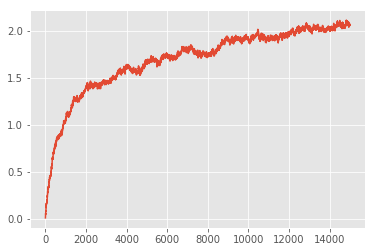

In [26]:
plt.plot(qmu_bs[-4][:,0])
plt.show()

## Bayesian Linear Regression for Undecided Voters

## Data

In [12]:
undecided_table = state_polls[['p_undecided', 'date_index', 'state_index']].as_matrix()
undecided_table = undecided_table[np.where(undecided_table[:, 0] != 0)[0]]
undecided = undecided_table[:, 0]
date_index = undecided_table[:, 1].astype(np.int32)
state_index = undecided_table[:, 2].astype(np.int32)

## Model

$$w_s = \textrm{Normal}(-0.05,  0.02)$$

$$b_s = \textrm{Normal}(8,  5)$$

$$u_s = \textrm{Normal}(w_s^T t + b,  4)$$

$$u_s \in \{0, ..., 100\}$$

In [13]:
w = Normal(loc=-0.05, scale=0.02 * tf.ones(n_states))
b = Normal(loc=8 + tf.zeros(n_states), scale=5 * tf.ones(n_states))
gat_w = tf.gather(w, state_index)
gat_b = tf.gather(b, state_index)
und = Normal(loc=gat_w * date_index + gat_b, scale=4.0)

## Inference

KLqp

In [14]:
qw = Normal(loc=tf.Variable(tf.random_normal([n_states])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_states]))))
qb = Normal(loc=tf.Variable(tf.random_normal([n_states])), scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_states]))))
inference = ed.KLqp({w: qw, b: qb}, data={und: undecided})
inference.run(n_samples=5, n_iter=10000)

10000/10000 [100%] ██████████████████████████████ Elapsed: 34s | Loss: 3029.840


Extract results

In [15]:
mean_w = qw.mean().eval()
mean_b = qb.mean().eval()

Create plots in ../plots/undecided_plots

In [16]:
i = 0
for s in states:
    generate_undecided_plot(undecided_table, i, s, mean_w, mean_b, E_day, save=True)
    i += 1

<img src="../plots/undecided_plots/michigan.png" alt="Drawing" style="width: 800px;"/>

## Predictions for Clinton Share of Two-Party Vote

For each posterior sample:

$$e = \textrm{Multivariate Normal}(0, \Sigma)$$

$$\Sigma = \textrm{cov-matrix}(\textrm{var}=2, \rho=0.75)$$

$$e = \textrm{logit}^{-1}(e)$$

    For state outcomes:

$$\pi^{clinton}[t,s] = \textrm{logit}^{-1} (\mu_a[t] + \mu_b[w_t, s]) \cdot (1 - u_s[t]) + e[s] \cdot u_s[t]$$

    For national outcome:

$$\pi^{clinton}[t, US] = \sum_{s \in S} \omega_s \cdot (\textrm{logit}^{-1} (\pi^{clinton}[t,s]))$$


In [41]:
predicted_scores = predict_scores(qmu_as, qmu_bs, E_day, mean_w, mean_b, var=2)
general_score = np.sum(state_weights_np * predicted_scores, axis=2)

clean_scores = predicted_scores[:, BURN_IN:, :]
e_day_results = clean_scores[-1, :, :]
e_day_general = general_score[-1, BURN_IN:]

In [53]:
i = 0
for s in states:
    state_s_polls = state_polls[state_polls.state == s]
    state_scores = predicted_scores[:, :, i]
    prior = prior_diff_score[s] + 0.486
    generate_time_plot(state_scores, state_s_polls, BURN_IN, s, prior, save=True)
    i += 1
    
generate_time_plot(general_score, national_polls, BURN_IN, "general", 0.486, save=True)

<img src="../plots/time_plots/general.png" alt="Drawing" style="width: 800px;"/>

<img src="../plots/time_plots/michigan.png" alt="Drawing" style="width: 800px;"/>

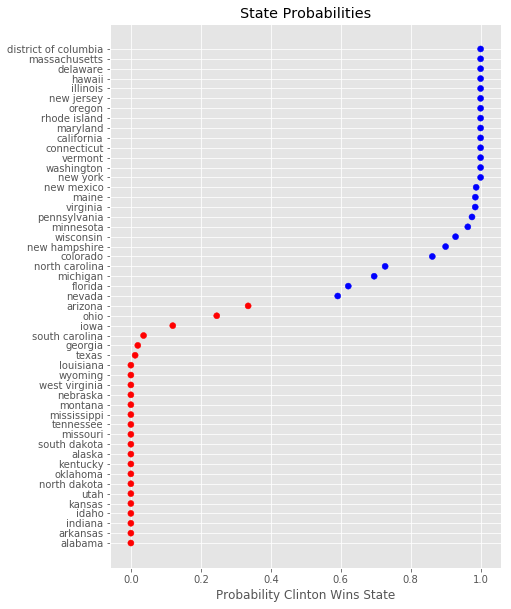

In [54]:
generate_state_probs(states, e_day_results)

### Simulate Election

Here we sample from predicted scores $10^4$ times and calculate:

$$\textrm{EV}_{Clinton} = \sum_{s \in S} \textrm{electoral_votes}[s] \cdot \mathbb{1}[\textrm{predicted_score}[T, s] > 0.5]$$

If $\textrm{EV}_{Clinton} > 270$ she wins that simulation of the election.

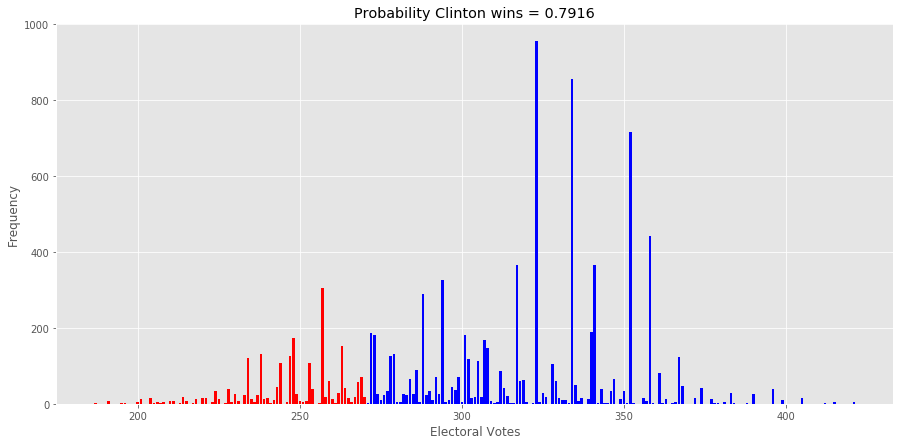

The probability Clinton loses the Electoral College but wins the popular vote is: 0.1567


In [55]:
clinton_loses_ec_but_wins, clinton_wins = generate_simulation_hist(e_day_results, e_day_general, ev_states)
print("The probability Clinton loses the Electoral College but wins the popular vote is:", clinton_loses_ec_but_wins)

538: The probability Clinton loses the Electoral College but wins the popular vote is: 0.105

### Brier Score

In [56]:
brier_score = get_brier_score(e_day_results, states)
weighted_brier_score = get_brier_score(e_day_results, states, weighted=True, ev_states=ev_states)
num_correct = get_correct(e_day_results, states)
print("Brier Score: {0:.4f}".format(brier_score))
print("EC Weighted Brier Score: {0:.4f}".format(weighted_brier_score))
print("Number Correct (Incl. DC): {0}".format(num_correct))

michigan
north carolina
wisconsin
pennsylvania
florida
Brier Score: 0.0706
EC Weighted Brier Score: 0.1082
Number Correct (Incl. DC): 46


<img src="images/brier_score.png" alt="Drawing" style="width: 600px;"/>

[image source](https://www.buzzfeed.com/jsvine/2016-election-forecast-grades?utm_term=.nqgbV0lxM#.rcr6KnwbD)

### Changing Undecided Variance

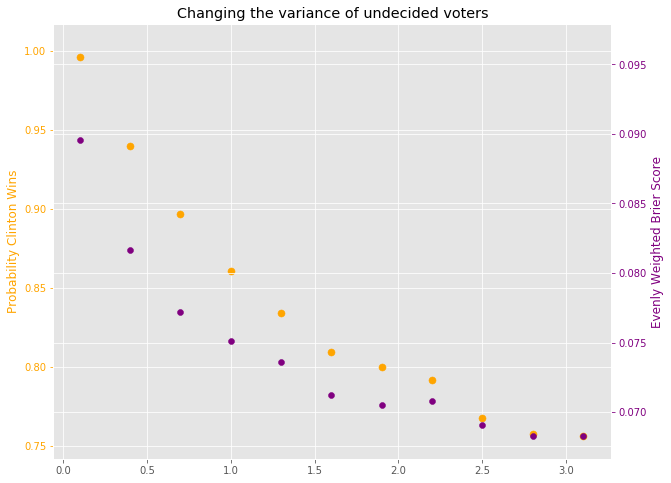

In [60]:
variance_test(qmu_as, qmu_bs, E_day, mean_w, mean_b, state_weights_np, ev_states, states, BURN_IN)